# Zestaw 9. Page Rank

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## 1. Prosty ranking wierzchołków

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym.</i>

#### generowanie grafów spójnych

W poniższych metodach niekorzystna jest sytuacja, w której w grafie istnieją wierzchołki ujścia, czyli takie, z których nie wychodzą krawędzie. Bez większego wpływu na istotę zagadnienia możemy takie wierzchołki usunąć. W dalszej części będę testować metody dla grafów silnie spójnych.

Generuję graf:

In [6]:
def get_connected_graph(n):
    graph = nx.generators.directed.random_k_out_graph(n, n-2, 3)
    nodes = max(nx.strongly_connected_components(graph), key=len)
    connected_graph = nx.DiGraph()
    for node in nodes:
        for edge in graph.out_edges(node):
            connected_graph.add_edge(*edge)
    return connected_graph

Dokonuję wizualizacji tego grafu:

In [13]:
def draw_graph(graph, pos):
    plt.figure(figsize=(10, 5))
    labels = {n: graph.nodes[n].get('weight', ' ') for n in graph.nodes}
    nx.draw(graph, pos=pos, with_labels=True, labels=labels, node_color='thistle', edge_color='silver')

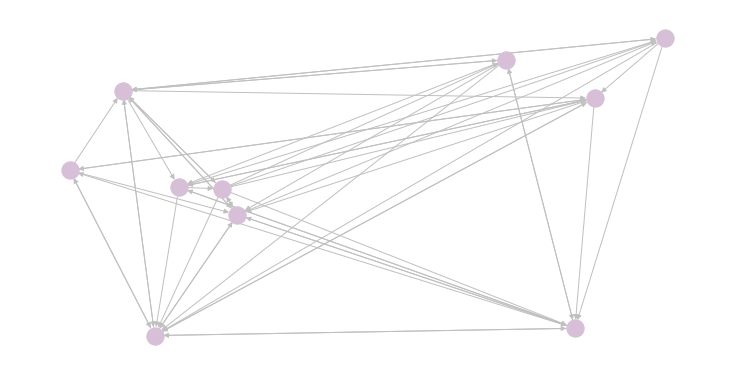

In [14]:
graph = get_connected_graph(10)
print(graph)
pos = nx.random_layout(graph)
draw_graph(graph, pos)

#### metoda potęgowa

Obydwie rozważane metody możemy sprowadzić do problemu znalezienia dominującego wektora własnego pewnej macierzy. Do znalezienia tego wektora posłuży poniższa funkcja implementująca metodę potęgową:

In [15]:
def power_method(A, epsilon=1e-8, max_iteration=100):
    def norm_inf(x): return np.linalg.norm(x, np.inf)
    def normalize(x): return x/np.linalg.norm(x, ord=1)
    
    n = A.shape[0]
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = norm_inf(x)
    x /= max_x
    iteration = 1
    
    while iteration < max_iteration and not np.allclose(x, prev_x, atol=epsilon) and not np.allclose(x, -prev_x, atol=epsilon):
        x, prev_x = A @ x, x
        max_x = norm_inf(x)
        x /= max_x
        iteration += 1
        
    return normalize(x)

#### ranking

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym</i>

Wartości liczb w rankingu są zadane następującą zależnością:
<center>$ r(u) = d \sum\frac{r(v)}{N_{v}}$</center>

We wzorze na wartość w rankingu jednego z wierzchołków pojawiają się wartości tego rankingu dla innych wierzchołków. Chcąc zastosować wzór wprost, najpewniej zapętlilibyśmy się. Wobec tego podchodzimy do tematu inaczej. Poprzez iteracyjną procedurę metody potęgowej jesteśmy w stanie znaleźć przybliżone wartości jako elementy dominującego wektora własnego macierzy A, gdzie wartości w tej macierzy reprezentują połączenie dwóch wierzchołków, przeskalowane przez liczbę wierzchołków wychodzących z węzła. Dzielimy przez liczbę wierzchołków wychodzących, aby zmniejszyć wpływ wierzchołków, a docelowo stron, które wskazują na wiele stron, nie świadcząc o przydatności każdego z wielu podlinkowanych łączy.

In [16]:
def simple_rank(graph, d=1):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
                
    r = power_method(d*A.T)
    
    for u in range(n):
        graph.nodes[nodes[u]]['weight'] = round(r[u], 3)
        
    return graph, r

In [17]:
graph, rank = simple_rank(graph)

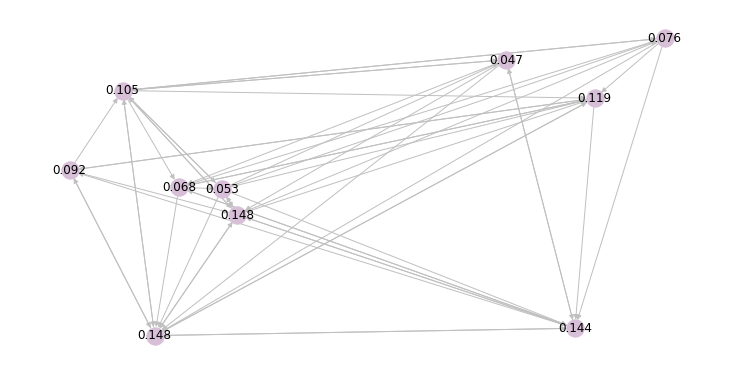

In [18]:
draw_graph(graph, pos)

#### testy

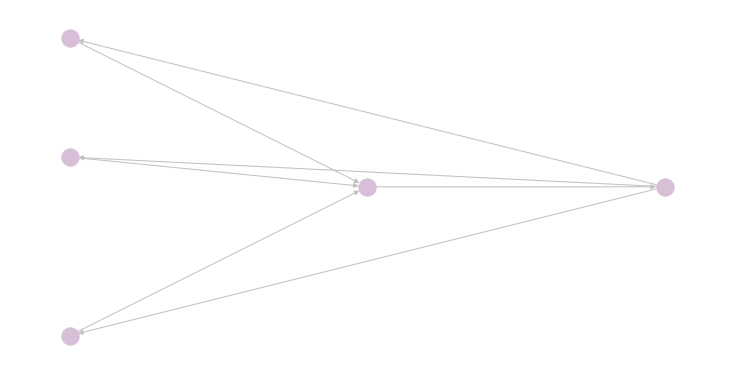

In [19]:
simple_graph = nx.DiGraph()
simple_graph.add_edge(0, 3)
simple_graph.add_edge(1, 3)
simple_graph.add_edge(2, 3)
simple_graph.add_edge(3, 4)
simple_graph.add_edge(4, 0)
simple_graph.add_edge(4, 1)
simple_graph.add_edge(4, 2)

pos = {0: (0, 0), 1: (0, 1.2), 2: (0, 2), 3: (1, 1), 4: (2, 1)}

draw_graph(simple_graph, pos)

2 \ <br>
1 - 3 - 4 <br>
0 /

Testy rozpoczynam od prostego grafu, na którym łatwo można prześledzić charakterystykę połączeń. Z wierzchołków o numerach 0, 1, 2 prowadzą krawędzie do wierzchołka nr 3. Wierzhołek nr 3 wskazuje na ten o numerze 4, który z kolei wskazuje na wierzchołki 0, 1 i 2. Można się spodziewać, iż najwyższa wartość w rankingu będzie przyznana wierzchołkowi nr 3, jako iż wchodzą do niego 3 krawędzie, a wychodzi tylko jedna.

rank:  [0.06666667 0.6        0.06666667 0.06666667 0.2       ]


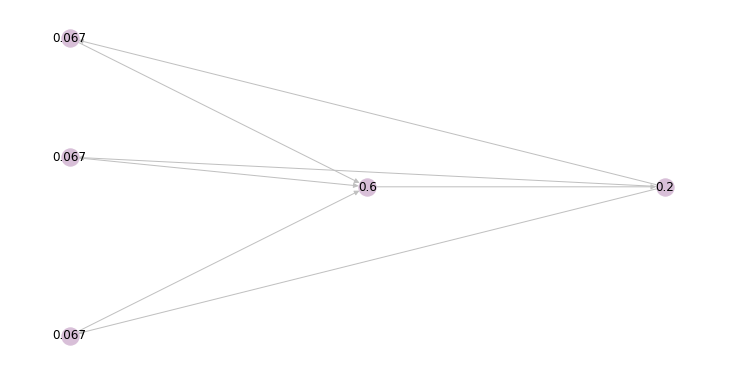

In [20]:
ranked_simple_graph, rank_ = simple_rank(simple_graph)
print('rank: ', rank_)
draw_graph(simple_graph, pos)

Zgodnie z oczekiwaniami największa wartość przyporządkowana została wierzchołkowi nr 3.  Stosunkową dużą wartością w rankingu cechuje się wierzchołek nr 4; mimo że wskazuje na niego tylko jeden wierzchołek, a on sam wskazuje na aż 3, to wskazujący na niego element ma finalnie powiązaną największą wartość, co zwiększa rangę wierzchołka nr 4.

Następnie generuję losowe spójne grafy i szukam dla nich ranking wierzchołków, wynik porównuję z wartościami otrzymanymi przez procedurę pagerank z biblioteki networkx, z wartością współczynnika normalizującego d ustawioną na 1, czyli ignorując wpływ wektora preferencji.

rank:  [0.17961578 0.05714841 0.15104802 0.07118644 0.11866154 0.13615379
 0.07891403 0.05106206 0.02024432 0.11365819 0.02230742]
networkx:  [0.17961565854621409, 0.057148129015451535, 0.1510483202492926, 0.07118648784253882, 0.11866143814174747, 0.13615397027894377, 0.07891422533141369, 0.05106192436528771, 0.020244123331488017, 0.11365836005554526, 0.022307362842076864]


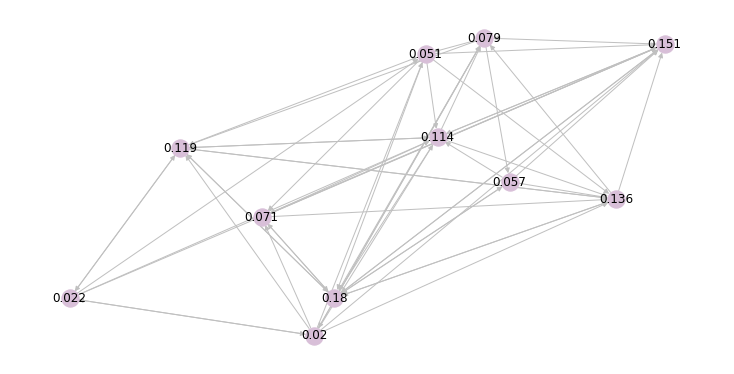

In [29]:
graph1 = get_connected_graph(11)
ranked_graph1, rank1 = simple_rank(graph1)
print('rank: ', rank1)
print('networkx: ', list(nx.algorithms.link_analysis.pagerank_alg.pagerank(graph1, alpha=1).values()))
draw_graph(ranked_graph1, nx.random_layout(ranked_graph1))

rank:  [0.06464636 0.0576392  0.03617584 0.03958758 0.05817415 0.05368755
 0.04548414 0.03702158 0.05896831 0.07457211 0.05168907 0.04867278
 0.03169167 0.06548066 0.03997519 0.06334597 0.0551169  0.05804867
 0.05021607 0.00980621]
networkx:  [0.06464638393910427, 0.05763919061225438, 0.03617583525407004, 0.03958757388433964, 0.058174362334952476, 0.053687625629592825, 0.0454841458522027, 0.0370214832538835, 0.05896830372379473, 0.07457217349477094, 0.05168899532392463, 0.04867279979398256, 0.03169160908480392, 0.06548062387082104, 0.03997519231923357, 0.06334595297286466, 0.05511691421163051, 0.05804863201773157, 0.05021609383583451, 0.009806108590207545]


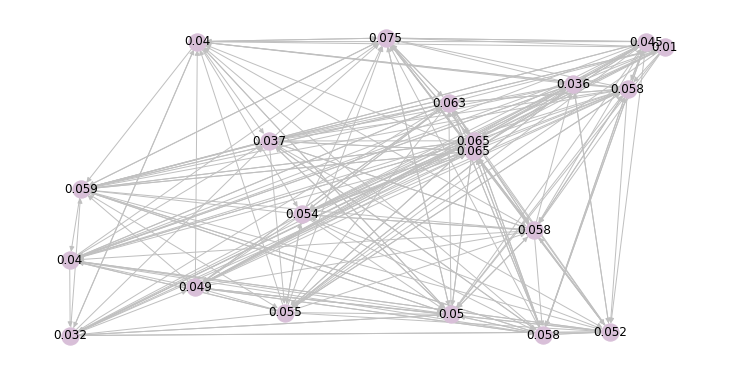

In [30]:
graph2 = get_connected_graph(20)
ranked_graph2, rank2 = simple_rank(graph2)
print('rank: ', rank2)
print('networkx: ', list(nx.algorithms.link_analysis.pagerank_alg.pagerank(graph2, alpha=1).values()))
draw_graph(ranked_graph2, nx.random_layout(ranked_graph2))

rank:  [0.03101997 0.00980566 0.02185181 0.01618658 0.02360812 0.0171577
 0.0337513  0.01634808 0.00772125 0.01499402 0.03141774 0.02228278
 0.01799154 0.02245322 0.02279607 0.01112629 0.0207155  0.03141629
 0.02709121 0.03168252 0.02170434 0.02419776 0.01897962 0.0138872
 0.0106041  0.02876971 0.02997338 0.02603329 0.02656077 0.01250536
 0.01490645 0.02981041 0.02257487 0.02403293 0.02193269 0.01317156
 0.03158841 0.01983918 0.02136246 0.01562219 0.02425848 0.01544984
 0.02128019 0.00703968 0.00680601 0.02443763 0.00344731 0.01598657
 0.00925078 0.01256918]
networkx:  [0.031019971106591566, 0.009805652681679175, 0.021851841005894306, 0.016186549876518866, 0.02360810937590759, 0.017157705419800717, 0.0337513075547007, 0.016348074780609952, 0.007721252700727498, 0.014994057858655287, 0.031417728935823425, 0.02228278966471337, 0.017991540413955173, 0.022453215558566657, 0.022796077606895986, 0.011126312646353895, 0.02071551259663894, 0.03141628008496015, 0.027091196739948475, 0.031682516

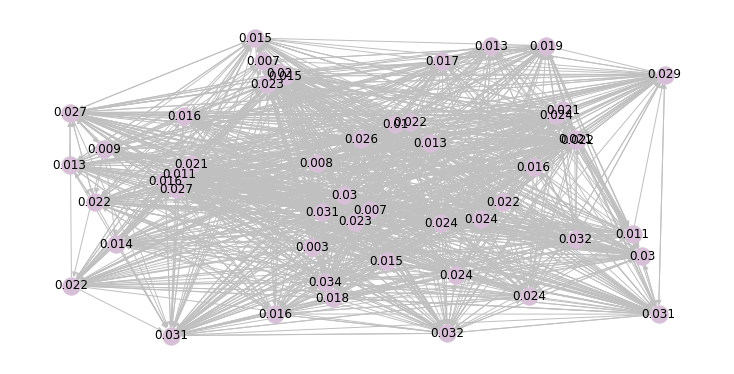

In [31]:
graph3 = get_connected_graph(50)
ranked_graph3, rank3 = simple_rank(graph3)
print('rank: ', rank3)
print('networkx: ', list(nx.algorithms.link_analysis.pagerank_alg.pagerank(graph3, alpha=1).values()))
draw_graph(ranked_graph3, nx.random_layout(ranked_graph3))

W powyższych przypadkach wygenerowane grafy są prawie że grafami pełnymi, a w związku z tym wartości w rankingu są do siebie zbliżone, żaden wierzchołek wyraźnie nie dominuje.

Uzyskane wyniki pokryły się z tymi otrzymanymi funkcją biblioteczną.

## 2. Page Rank

<i>Rozszerz model z poprzedniego zadania, dodając możliwość skoku do losowego wierzchołka grafu.</i>

Prawdopodobieństwo skoku do każdego z wierzchołków reprezentuje wektor e. Liczba d jest natomiast wykorzystana do normalizacji i określa zadany wpływ tychże potencjalnych skoków w rozważanym modelu. 

Postępuję podobnie do punktu 1. jednak modyfikuję odpowiednio macierz tak, aby uwzględnić wektor e z wagą (1-d).

In [32]:
def page_rank(graph, d, e, add_labels=False):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
    
    
    B = d*A + (1-d)*e
    
    r = power_method(B.T)
    
    if add_labels:
        for i in range(n):
            graph.nodes[nodes[i]]['weight'] = round(r[i], 3)
    
    return graph, {nodes[i]: round(r[i], 3) for i in range(n)}

Następnie implementuję prostą funkcję, wykorzystującą biblioteczną procedurę znajdowania modelu PageRank, w celu weryfikacji otrzymanych wyników:

In [33]:
def nx_page_rank(graph, d, e):
    nodes = list(graph.nodes())
    personalization = {nodes[i]: e[i] for i in range(graph.number_of_nodes())}
    rank = nx.algorithms.link_analysis.pagerank_alg.pagerank(graph, alpha=d, personalization=personalization)
    return {key: round(rank[key], 3) for key in rank}

## Testy

#### przykładowy graf

Najpierw przeprowadzam testy dla prostego grafu z poprzedniej części.

Możemy zauważyć, że dla d=1 wynik jest tożsamy z tym otrzymanym dla prostego rankingu wierzchołków w punkcie 1:

rank:  {0: 0.067, 3: 0.6, 1: 0.067, 2: 0.067, 4: 0.2}


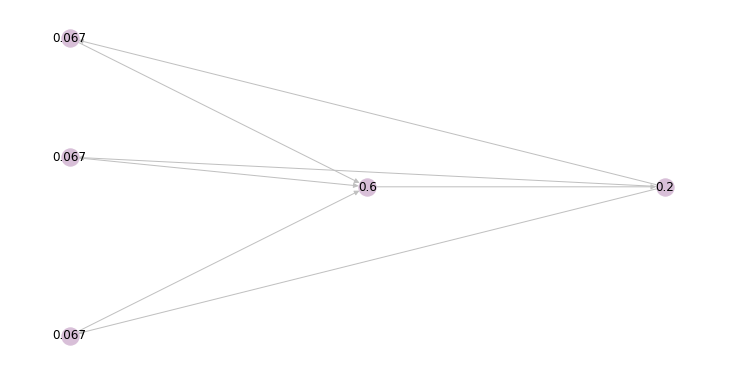

In [47]:
d = 1
e = np.ones(len(simple_graph))/len(simple_graph)

ranked_simple_graph, rank_ = page_rank(simple_graph, d, e, True)
print('rank: ', rank_)
draw_graph(ranked_simple_graph, pos)

Przy wartości d = 0.85 oraz standardowym wektorze e, zauważamy lekką różnicą w stosunku do prostego rankingu w punkcie 1. Mimo różniących się nieco wartości, pozycje w rankingu nie uległy zmianie. Wynika to z przyjętego wektora e, który nie wprowadza preferencji ukierunkowanych na konkretny wierzchołek:

rank:  {0: 0.118, 3: 0.332, 1: 0.118, 2: 0.118, 4: 0.312}
networkx:  {0: 0.118, 3: 0.332, 1: 0.118, 2: 0.118, 4: 0.312}


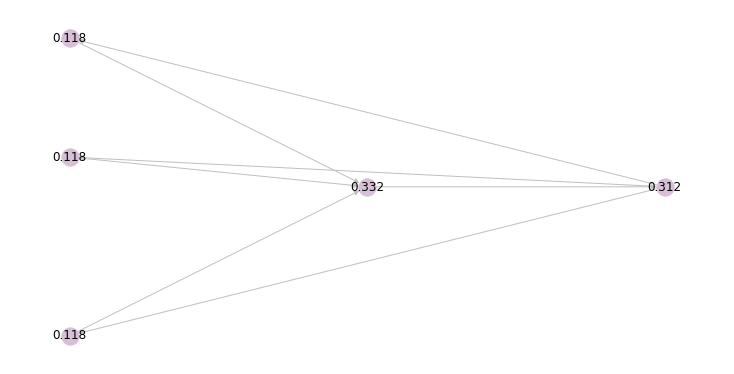

In [48]:
d = 0.85
e = np.ones(len(simple_graph))/len(simple_graph)

ranked_simple_graph, rank_ = page_rank(simple_graph, d, e, True)
print('rank: ', rank_)
print('networkx: ', nx_page_rank(simple_graph, d, e))
draw_graph(ranked_simple_graph, pos)

W poniższym przykładzie dobrany wektor e wprowadził do układu duże prawdopodobieństwo przeskoku do wierzchołka nr 0. Dzięki temu wartość tegoż wierzchołka bardzo wzrosła w stosunku do wcześniej nierozróżnialnych z nim wierzchołków 1 i 2.

rank:  {0: 0.23, 3: 0.33, 1: 0.08, 2: 0.08, 4: 0.281}
networkx:  {0: 0.23, 3: 0.33, 1: 0.08, 2: 0.08, 4: 0.281}


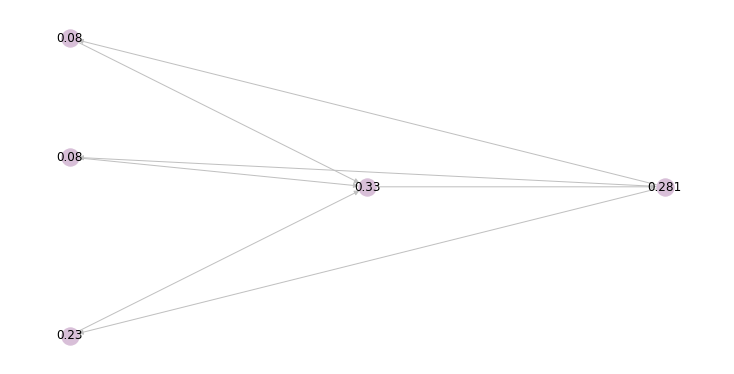

In [49]:
d = 0.85
e = np.zeros(len(simple_graph))
e[0] = 1

ranked_simple_graph, rank_ = page_rank(simple_graph, d, e, True)
print('rank: ', rank_)
print('networkx: ', nx_page_rank(simple_graph, d, e))
draw_graph(ranked_simple_graph, pos)

Następnie, dokonuję testów dla losowych grafów silnie spójnych, porównując wyniki z wartościami otrzymanymi przy użyciu funkcji z biblioteki networkx.

In [50]:
def test_page_rank(graph, e=None, d=0.85, print_highest=False):
    if e is None:
        n = graph.number_of_nodes()
        e = np.ones(n)/n
        
    graph, rank = page_rank(graph, d, e)
    
    if print_highest:
        print(sorted(rank.items(), key=lambda x:x[1], reverse=True)[:10])
        return

    print('e: ', e)
    print('rank: ', rank)
    print('nx rank: ', nx_page_rank(graph, d, e))
    print('max rank: ', max(rank.items(), key=lambda x: x[1]))

#### dla różnych wektorów e

dla e o rozkładzie jednopunktowym

In [51]:
n = graph.number_of_nodes()
test_page_rank(graph, np.ones(n)/n)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.14, 1: 0.138, 2: 0.081, 3: 0.105, 6: 0.06, 5: 0.142, 9: 0.073, 8: 0.054, 7: 0.091, 4: 0.117}
nx rank:  {0: 0.14, 1: 0.138, 2: 0.081, 3: 0.105, 6: 0.06, 5: 0.142, 9: 0.073, 8: 0.054, 7: 0.091, 4: 0.117}
max rank:  (5, 0.142)


wektor e z przewagą wartości dla jednego z wierzchołków

In [52]:
n = graph.number_of_nodes()
e = np.zeros(n)
e[0] = 1

test_page_rank(graph, e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.277, 1: 0.126, 2: 0.08, 3: 0.098, 6: 0.059, 5: 0.127, 9: 0.048, 8: 0.037, 7: 0.062, 4: 0.085}
nx rank:  {0: 0.277, 1: 0.126, 2: 0.08, 3: 0.098, 6: 0.059, 5: 0.127, 9: 0.048, 8: 0.037, 7: 0.062, 4: 0.085}
max rank:  (0, 0.277)


Wektor e reprezentuje prawdopodobieństwo odwiedzenia wierzchołków przez losowy skok. Dzięki niemu jesteśmy w stanie uwzględnić znane preferencje w rankingu i w pewnym stopniu spersonalizować wynik wyszukiwania, np. pod względem kategorii, którymi interesuje się użytkownik.

#### dla różnych wartości d

In [61]:
test_page_rank(graph, d=0.9, e=e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.234, 1: 0.132, 2: 0.08, 3: 0.101, 6: 0.058, 5: 0.134, 9: 0.054, 8: 0.04, 7: 0.071, 4: 0.096}
nx rank:  {0: 0.234, 1: 0.132, 2: 0.08, 3: 0.101, 6: 0.058, 5: 0.134, 9: 0.054, 8: 0.04, 7: 0.071, 4: 0.096}
max rank:  (0, 0.234)


In [62]:
test_page_rank(graph, d=0.85, e=e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.277, 1: 0.126, 2: 0.08, 3: 0.098, 6: 0.059, 5: 0.127, 9: 0.048, 8: 0.037, 7: 0.062, 4: 0.085}
nx rank:  {0: 0.277, 1: 0.126, 2: 0.08, 3: 0.098, 6: 0.059, 5: 0.127, 9: 0.048, 8: 0.037, 7: 0.062, 4: 0.085}
max rank:  (0, 0.277)


In [63]:
test_page_rank(graph, d=0.75, e=e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.363, 1: 0.113, 2: 0.079, 3: 0.092, 6: 0.061, 5: 0.113, 9: 0.037, 8: 0.031, 7: 0.046, 4: 0.066}
nx rank:  {0: 0.363, 1: 0.113, 2: 0.079, 3: 0.092, 6: 0.061, 5: 0.113, 9: 0.037, 8: 0.031, 7: 0.046, 4: 0.066}
max rank:  (0, 0.363)


In [64]:
test_page_rank(graph, d=0.6, e=e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.491, 1: 0.093, 2: 0.072, 3: 0.08, 6: 0.059, 5: 0.092, 9: 0.023, 8: 0.021, 7: 0.028, 4: 0.042}
nx rank:  {0: 0.491, 1: 0.093, 2: 0.072, 3: 0.08, 6: 0.059, 5: 0.092, 9: 0.023, 8: 0.021, 7: 0.028, 4: 0.042}
max rank:  (0, 0.491)


In [65]:
test_page_rank(graph, d=0.5, e=e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.577, 1: 0.078, 2: 0.065, 3: 0.07, 6: 0.055, 5: 0.077, 9: 0.015, 8: 0.015, 7: 0.019, 4: 0.029}
nx rank:  {0: 0.577, 1: 0.078, 2: 0.065, 3: 0.07, 6: 0.055, 5: 0.077, 9: 0.015, 8: 0.015, 7: 0.019, 4: 0.029}
max rank:  (0, 0.577)


Im mniejsza wartość współczynnika d, tym większy wpływ na ranking ma wprowadzony wektor e przeskoków do losowego wierzchołka, co widać na powyższych przykładach. Dla wektora definiującego duże prawdopodobieństwo przeskoku do wierzchołka 0, malejąca wartość d wpływała na rosnącą wartość dla tegoż wierzchołka w rankingu i jego finalne wysunięcie się na prowadzenie.

#### graf z bazy Snap

Poniższa funkcja tworzy graf na podstawie pliku z danymi z bazy:

In [58]:
def graph_from_file(file_name):
    graph = nx.DiGraph()
    with open(file_name, 'r') as f:
        next(f)
        for line in f:
            if line[0] == '#': continue
            u, v = line.split('\t')[:2]
            u = u.strip()
            v = v.strip()
            graph.add_edge(u, v)
    return graph

Testuję działanie funkcji dla danych z bazy Snap. Poniższy plik zawiera informacje o hiperlinkach z jednego subforum do innego na portalu Reddit. Będziemy chcięli znaleźć najpopularniejsze/najważniejsze subfora tego portalu, wykorzystując model PageRank.

In [59]:
graph_reddit = graph_from_file('soc-redditHyperlinks-body.tsv')

In [60]:
# test_page_rank(graph_reddit, print_highest=True)

[('iama', 0.012), ('askreddit', 0.012), ('pics', 0.006), ('videos', 0.006), ('leagueoflegends', 0.004), ('todayilearned', 0.004), ('funny', 0.004), ('writingprompts', 0.004), ('gaming', 0.004), ('outoftheloop', 0.004)]


Subreddits o najwyższej wartości w rankingu to 'IAmA' oraz 'askreddit'. Pokrywa się to z oczekiwaniami, zważywszy na fakt, że subreddit 'IAmA' ma 21 milionów członków, stworzono go w roku 2009, natomiast 'askreddit' posiada 32.4 miliona użytkowników, powstał w 2008 roku. Obydwa te fora są często udostępniane w innych częściach tego serwisu, co wpłynęło na ich wysoką wartość w rankingu.

Wpisując w wyszukiwarkę Google frazę r/ pierwszą podpowiedzią było dla mnie właśnie r/askreddit.

## Wnioski

 - Dzięki dekompozycji spektralnej często jesteśmy w stanie rozwiązać problem określony zależnością niejawną/uwikłaną.
 - Algorytm PageRank ma swoje zastosowanie przy sortowaniu stron internetowych w wyszukiwarce, dzięki czemu najważniejsze źródła znajdują się na samej górze.
 - Przez wprowadzenie wektora e i d możemy modelować zagadnienie tak, aby dobrze reprezentowało specyfikę problemu. Możemy np. dzięki tym parametrom wprowadzić do modelu preferencje użytkownika, dla którego szukamy ranking stron.
 - Dla bardzo dużych grafów czas działania tej metody jest duży oraz może się wiązać z dużymi błędami obliczeń, również dlatego, iż wartości dla każdego z wierzchołków będą w ogólności bardzo małe.

M. Hawryluk 27.05.2021